# Features in previous_application

In [690]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from dython.nominal import associations

# set config to output pandas dataframes
from sklearn import set_config
set_config(transform_output='pandas')


### set up system path to access helpers functions
import sys, os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
  sys.path.append(src_path)

# import helpers
from helpers import *


In [691]:
# import the data

df = pd.read_csv('../data/previous_application.csv')

df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [692]:
# check the data of 1 row to get an understanding of what the values looks like

df.iloc[0]

SK_ID_PREV                                      2030495
SK_ID_CURR                                       271877
NAME_CONTRACT_TYPE                       Consumer loans
AMT_ANNUITY                                     1730.43
AMT_APPLICATION                                 17145.0
AMT_CREDIT                                      17145.0
AMT_DOWN_PAYMENT                                    0.0
AMT_GOODS_PRICE                                 17145.0
WEEKDAY_APPR_PROCESS_START                     SATURDAY
HOUR_APPR_PROCESS_START                              15
FLAG_LAST_APPL_PER_CONTRACT                           Y
NFLAG_LAST_APPL_IN_DAY                                1
RATE_DOWN_PAYMENT                                   0.0
RATE_INTEREST_PRIMARY                          0.182832
RATE_INTEREST_PRIVILEGED                       0.867336
NAME_CASH_LOAN_PURPOSE                              XAP
NAME_CONTRACT_STATUS                           Approved
DAYS_DECISION                                   

### Exploring the features

- RATE_DOWN_PAYMENT = percentage of the total loan amount adjusted relative to the loan amount, assess borrower commitment: higher down payment usually means lower risk for the lender.

- RATE_INTEREST_PRIMARY = normalized to market rates

- RATE_INTEREST_PRIVILEGED = special, interest rate, possibly lower than primary, they may qualify due to good credit history, or lender promotions. 



Features to engineer:

1. credit_approved_rate = AMT_CREDIT / AMT_APPLICATION ==> the final loan amount / how much the client asked for
    - if final amount is a lot less than what the client applied for may indicate credit concerns
2. OHE reject reasons
3. OHE name yield
4. OHE cash loan purpose

In [693]:
# define the OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [694]:
# create a new Engineered Dataframe to gather the engineered features

engineered_prev = pd.DataFrame(df['SK_ID_CURR'].copy())

engineered_prev.drop_duplicates(keep='first', inplace=True)

engineered_prev

,SK_ID_CURR
0,271877
1,108129
2,122040
3,176158
4,202054
...,...
1669619,239799
1669655,174832
1669726,253940
1669862,353284


### New feature: prev_credit_approved_ratio

prev_credit_approved_ratio = AMT_CREDIT / AMT_APPLICATION
- the final loan amount / how much the client asked for
- if final amount is a lot less than what the client applied for may indicate credit concerns

In [695]:
# check values counts for AMT_CREDIT

df['AMT_CREDIT'].value_counts()

AMT_CREDIT
0.00         336768
45000.00      35051
225000.00     21094
450000.00     19954
135000.00     18720
              ...  
262768.50         1
354213.00         1
438817.50         1
253111.50         1
436370.22         1
Name: count, Length: 86803, dtype: int64

In [696]:
# check value counts for AMT_APPLICATION

df['AMT_APPLICATION'].value_counts()

AMT_APPLICATION
0.00         392402
45000.00      47831
225000.00     43543
135000.00     40678
450000.00     38905
              ...  
185292.00         1
225054.00         1
156212.55         1
99896.31          1
267295.50         1
Name: count, Length: 93885, dtype: int64

In [697]:
# calculate the ratio of AMT_CREDIT to AMT_APPLICATION

df['prev_ratio_credit_approved'] = df['AMT_CREDIT'] / df['AMT_APPLICATION']
df['prev_ratio_credit_approved'].describe()

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.333446e+06
mean              inf
std               NaN
min      0.000000e+00
25%      9.890968e-01
50%      1.000000e+00
75%      1.116161e+00
max               inf
Name: prev_ratio_credit_approved, dtype: float64

- inf mean 0 in AMT_APPLICATION, which means there was no credit requested. Dividing by 0 will result in inf. Replace inf with 1, because a ratio closer to 1 means the client received as much credit as they applied for. But if they applied for nothing, then it would be incorrect to associate with 0, but more appropriate to indicate with 1. 

In [698]:
# replace inf with 1

df['prev_ratio_credit_approved'] = df['prev_ratio_credit_approved'].replace({np.inf: 1})
df['prev_ratio_credit_approved']

0          1.000000
1          1.118800
2          1.212840
3          1.046200
4          1.197200
             ...   
1670209    1.165003
1670210    0.732667
1670211    0.974215
1670212    1.066000
1670213    1.000000
Name: prev_ratio_credit_approved, Length: 1670214, dtype: float64

In [699]:
# groupby SK_ID_CURR and average the values

ratio_credit_approved = pd.DataFrame(df.groupby('SK_ID_CURR')['prev_ratio_credit_approved'].mean()).reset_index()
ratio_credit_approved.columns = ['SK_ID_CURR','prev_avg_ratio_credit_approved']
ratio_credit_approved

,SK_ID_CURR,prev_avg_ratio_credit_approved
0,100001,0.957782
1,100002,1.000000
2,100003,1.057664
3,100004,0.828021
4,100005,0.899950
...,...,...
338852,456251,1.000000
338853,456252,0.986561
338854,456253,0.831397
338855,456254,1.122050


In [700]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, ratio_credit_approved, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved
0,100001,0.957782
1,100002,1.000000
2,100003,1.057664
3,100004,0.828021
4,100005,0.899950
...,...,...
338852,456251,1.000000
338853,456252,0.986561
338854,456253,0.831397
338855,456254,1.122050


### CODE_REJECT_REASON

In [701]:
# check the values

df['CODE_REJECT_REASON'].value_counts()

CODE_REJECT_REASON
XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: count, dtype: int64

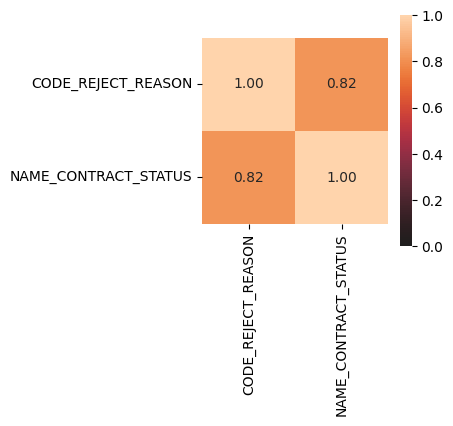

{'corr':                       CODE_REJECT_REASON  NAME_CONTRACT_STATUS
 CODE_REJECT_REASON              1.000000              0.816487
 NAME_CONTRACT_STATUS            0.816487              1.000000,
 'ax': <Axes: >}

In [702]:
associations(df[['CODE_REJECT_REASON','NAME_CONTRACT_STATUS']])

In [703]:
# separate the feature along with a copy of the 2 ID columns

reject_reason_df = df[['SK_ID_CURR', 'SK_ID_PREV', 'CODE_REJECT_REASON']].copy()
reject_reason_df

,SK_ID_CURR,SK_ID_PREV,CODE_REJECT_REASON
0,271877,2030495,XAP
1,108129,2802425,XAP
2,122040,2523466,XAP
3,176158,2819243,XAP
4,202054,1784265,HC
...,...,...,...
1670209,352015,2300464,XAP
1670210,334635,2357031,XAP
1670211,249544,2659632,XAP
1670212,400317,2785582,XAP


In [704]:
# define a column transformer to transform feature

reject_preprocessor = ColumnTransformer([
  ('ohe', ohe, ['CODE_REJECT_REASON'])
], remainder='passthrough', verbose_feature_names_out=False)

ohe_reject_reason = reject_preprocessor.fit_transform(reject_reason_df)
ohe_reject_reason

,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,SK_ID_CURR,SK_ID_PREV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,271877,2030495
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,108129,2802425
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,122040,2523466
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,176158,2819243
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202054,1784265
...,...,...,...,...,...,...,...,...,...,...,...
1670209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,352015,2300464
1670210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,334635,2357031
1670211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,249544,2659632
1670212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,400317,2785582


In [705]:
# rename columns to be consistent with other engineered features

ohe_reject_reason = ohe_reject_reason.rename(columns={
  'CODE_REJECT_REASON_CLIENT': 'prev_reject_CLIENT',
  'CODE_REJECT_REASON_HC': 'prev_reject_HC',
  'CODE_REJECT_REASON_LIMIT': 'prev_reject_LIMIT',
  'CODE_REJECT_REASON_SCO': 'prev_reject_SCO',
  'CODE_REJECT_REASON_SCOFR': 'prev_reject_SCOFR',
  'CODE_REJECT_REASON_SYSTEM': 'prev_reject_SYSTEM',
  'CODE_REJECT_REASON_VERIF': 'prev_reject_VERIF',
  'CODE_REJECT_REASON_XAP': 'prev_reject_XAP',
  'CODE_REJECT_REASON_XNA': 'prev_reject_XNA'
})

ohe_reject_reason

,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,SK_ID_CURR,SK_ID_PREV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,271877,2030495
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,108129,2802425
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,122040,2523466
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,176158,2819243
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202054,1784265
...,...,...,...,...,...,...,...,...,...,...,...
1670209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,352015,2300464
1670210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,334635,2357031
1670211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,249544,2659632
1670212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,400317,2785582


In [706]:
# groupby SK_ID_CURR and sum the columns

ohe_reject_reason = ohe_reject_reason.groupby('SK_ID_CURR').sum()

# drop SK_ID_PREV
ohe_reject_reason.drop(columns='SK_ID_PREV', inplace=True)

# reset index
ohe_reject_reason = ohe_reject_reason.reset_index()

ohe_reject_reason

,SK_ID_CURR,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA
0,100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
338852,456251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338853,456252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338854,456253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
338855,456254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [707]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, ohe_reject_reason, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


### CODE_REJECT_REASON 2 - binary rejected or not

In [708]:
# create a new feature for whether or not the previous application was rejected

binary_rejected = df[['SK_ID_CURR', 'SK_ID_PREV', 'CODE_REJECT_REASON']].copy()
binary_rejected['prev_binary_rejected'] = (df['CODE_REJECT_REASON'] != 'XAP').astype(int)
binary_rejected

,SK_ID_CURR,SK_ID_PREV,CODE_REJECT_REASON,prev_binary_rejected
0,271877,2030495,XAP,0
1,108129,2802425,XAP,0
2,122040,2523466,XAP,0
3,176158,2819243,XAP,0
4,202054,1784265,HC,1
...,...,...,...,...
1670209,352015,2300464,XAP,0
1670210,334635,2357031,XAP,0
1670211,249544,2659632,XAP,0
1670212,400317,2785582,XAP,0


In [709]:
# drop unnecessary columns

binary_rejected.drop(columns=['SK_ID_PREV','CODE_REJECT_REASON'], inplace=True)

# group by SK_ID_CURR, sum the values
binary_rejected = pd.DataFrame(binary_rejected.groupby('SK_ID_CURR').sum()).reset_index()
binary_rejected

,SK_ID_CURR,prev_binary_rejected
0,100001,0
1,100002,0
2,100003,0
3,100004,0
4,100005,0
...,...,...
338852,456251,0
338853,456252,0
338854,456253,0
338855,456254,0


In [710]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, binary_rejected, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0


### NAME_CONTRACT_STATUS

In [711]:
# check values

df['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64

In [712]:
# separate columns

contract_status_df = df[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_STATUS']].copy()
contract_status_df

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS
0,271877,2030495,Approved
1,108129,2802425,Approved
2,122040,2523466,Approved
3,176158,2819243,Approved
4,202054,1784265,Refused
...,...,...,...
1670209,352015,2300464,Approved
1670210,334635,2357031,Approved
1670211,249544,2659632,Approved
1670212,400317,2785582,Approved


In [713]:
# create binary columns for all the value types

contract_status_df['prev_status_approved'] = (df['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)
contract_status_df['prev_status_canceled'] = (df['NAME_CONTRACT_STATUS'] == 'Canceled').astype(int)
contract_status_df['prev_status_refused'] = (df['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)
contract_status_df['prev_status_unused'] = (df['NAME_CONTRACT_STATUS'] == 'Unused offer').astype(int)

contract_status_df

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused
0,271877,2030495,Approved,1,0,0,0
1,108129,2802425,Approved,1,0,0,0
2,122040,2523466,Approved,1,0,0,0
3,176158,2819243,Approved,1,0,0,0
4,202054,1784265,Refused,0,0,1,0
...,...,...,...,...,...,...,...
1670209,352015,2300464,Approved,1,0,0,0
1670210,334635,2357031,Approved,1,0,0,0
1670211,249544,2659632,Approved,1,0,0,0
1670212,400317,2785582,Approved,1,0,0,0


In [714]:
# drop  unnecessary columns

contract_status_df.drop(columns=['NAME_CONTRACT_STATUS','SK_ID_PREV'], inplace=True)
contract_status_df


,SK_ID_CURR,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused
0,271877,1,0,0,0
1,108129,1,0,0,0
2,122040,1,0,0,0
3,176158,1,0,0,0
4,202054,0,0,1,0
...,...,...,...,...,...
1670209,352015,1,0,0,0
1670210,334635,1,0,0,0
1670211,249544,1,0,0,0
1670212,400317,1,0,0,0


In [715]:
# groupby SK_ID_CURR, sum the values

binary_contract_status = contract_status_df.groupby('SK_ID_CURR').sum()
binary_contract_status = binary_contract_status.reset_index()
binary_contract_status


,SK_ID_CURR,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused
0,100001,1,0,0,0
1,100002,1,0,0,0
2,100003,3,0,0,0
3,100004,1,0,0,0
4,100005,1,1,0,0
...,...,...,...,...,...
338852,456251,1,0,0,0
338853,456252,1,0,0,0
338854,456253,2,0,0,0
338855,456254,2,0,0,0


In [716]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, binary_contract_status, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0


### NAME_YIELD_GROUP

In [717]:
# check the value counts

df['NAME_YIELD_GROUP'].value_counts()

NAME_YIELD_GROUP
XNA           517215
middle        385532
high          353331
low_normal    322095
low_action     92041
Name: count, dtype: int64

In [718]:
# separate the columns from the df

name_yield_group = df[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_YIELD_GROUP']].copy()

name_yield_group

,SK_ID_CURR,SK_ID_PREV,NAME_YIELD_GROUP
0,271877,2030495,middle
1,108129,2802425,low_action
2,122040,2523466,high
3,176158,2819243,middle
4,202054,1784265,high
...,...,...,...
1670209,352015,2300464,low_normal
1670210,334635,2357031,middle
1670211,249544,2659632,low_normal
1670212,400317,2785582,low_normal


In [719]:
# ohe the NAME_YIELD_GROUP column using a column transformer

yield_group_preprocess = ColumnTransformer([
  ('ohe', ohe, ['NAME_YIELD_GROUP'])
], remainder='passthrough', verbose_feature_names_out=False)

ohe_yield_group = yield_group_preprocess.fit_transform(name_yield_group)
ohe_yield_group

,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,SK_ID_CURR,SK_ID_PREV
0,0.0,0.0,0.0,0.0,1.0,271877,2030495
1,0.0,0.0,1.0,0.0,0.0,108129,2802425
2,0.0,1.0,0.0,0.0,0.0,122040,2523466
3,0.0,0.0,0.0,0.0,1.0,176158,2819243
4,0.0,1.0,0.0,0.0,0.0,202054,1784265
...,...,...,...,...,...,...,...
1670209,0.0,0.0,0.0,1.0,0.0,352015,2300464
1670210,0.0,0.0,0.0,0.0,1.0,334635,2357031
1670211,0.0,0.0,0.0,1.0,0.0,249544,2659632
1670212,0.0,0.0,0.0,1.0,0.0,400317,2785582


In [720]:
# rename columns to be consistent with other engineered features

ohe_yield_group = ohe_yield_group.rename(columns={
  'NAME_YIELD_GROUP_XNA':'prev_yield_XNA',
  'NAME_YIELD_GROUP_high': 'prev_yield_high',
  'NAME_YIELD_GROUP_low_action': 'prev_yield_low_action',
  'NAME_YIELD_GROUP_low_normal': 'prev_yield_low_normal',
  'NAME_YIELD_GROUP_middle': 'prev_yield_middle'
})

ohe_yield_group

,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle,SK_ID_CURR,SK_ID_PREV
0,0.0,0.0,0.0,0.0,1.0,271877,2030495
1,0.0,0.0,1.0,0.0,0.0,108129,2802425
2,0.0,1.0,0.0,0.0,0.0,122040,2523466
3,0.0,0.0,0.0,0.0,1.0,176158,2819243
4,0.0,1.0,0.0,0.0,0.0,202054,1784265
...,...,...,...,...,...,...,...
1670209,0.0,0.0,0.0,1.0,0.0,352015,2300464
1670210,0.0,0.0,0.0,0.0,1.0,334635,2357031
1670211,0.0,0.0,0.0,1.0,0.0,249544,2659632
1670212,0.0,0.0,0.0,1.0,0.0,400317,2785582


In [721]:
# groupby SK_ID_CURR and sum the values

ohe_yield_group = ohe_yield_group.groupby('SK_ID_CURR').sum()

# drop SK_ID_PREV
ohe_yield_group.drop(columns='SK_ID_PREV', inplace=True)

# reset index
ohe_yield_group.reset_index(inplace=True)

ohe_yield_group

,SK_ID_CURR,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle
0,100001,0.0,1.0,0.0,0.0,0.0
1,100002,0.0,0.0,0.0,1.0,0.0
2,100003,0.0,0.0,0.0,1.0,2.0
3,100004,0.0,0.0,0.0,0.0,1.0
4,100005,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
338852,456251,0.0,1.0,0.0,0.0,0.0
338853,456252,0.0,0.0,0.0,1.0,0.0
338854,456253,0.0,2.0,0.0,0.0,0.0
338855,456254,0.0,1.0,0.0,1.0,0.0


In [722]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, ohe_yield_group, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0,0.0,0.0,0.0,1.0,2.0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,2.0,0.0,0.0,0.0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,1.0,0.0,1.0,0.0


### NFLAG_INSURED_ON_APPROVAL

In [723]:
# check the value counts

df['NFLAG_INSURED_ON_APPROVAL'].value_counts()

NFLAG_INSURED_ON_APPROVAL
0.0    665527
1.0    331622
Name: count, dtype: int64

In [724]:
# check for nulls

df['NFLAG_INSURED_ON_APPROVAL'].isna().sum() / df['NFLAG_INSURED_ON_APPROVAL'].shape

array([0.40298129])

In [725]:
# fillna with 0

df['NFLAG_INSURED_ON_APPROVAL'] = df['NFLAG_INSURED_ON_APPROVAL'].fillna(0)

In [726]:
# separate column and group by SK_ID_CURR by taking the sum of values

binary_insured = df[['SK_ID_CURR', 'SK_ID_PREV', 'NFLAG_INSURED_ON_APPROVAL']].copy()

# group by SK_ID_CURR
binary_insured = binary_insured.groupby('SK_ID_CURR').sum()

# drop SK_ID_PREV
binary_insured.drop(columns='SK_ID_PREV', inplace=True)

# reset index
binary_insured.reset_index(inplace=True)

# rename columns
binary_insured.columns = ['SK_ID_CURR', 'prev_insured']

binary_insured

,SK_ID_CURR,prev_insured
0,100001,0.0
1,100002,0.0
2,100003,2.0
3,100004,0.0
4,100005,0.0
...,...,...
338852,456251,0.0
338853,456252,1.0
338854,456253,1.0
338855,456254,1.0


In [727]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, binary_insured, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle,prev_insured
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,2.0,0.0,0.0,0.0,1.0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0


### NAME_CONTRACT_TYPE

In [728]:
# check value counts

df['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: count, dtype: int64

In [729]:
# separate column from df

contract_type_df = df[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE']].copy()
contract_type_df

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_TYPE
0,271877,2030495,Consumer loans
1,108129,2802425,Cash loans
2,122040,2523466,Cash loans
3,176158,2819243,Cash loans
4,202054,1784265,Cash loans
...,...,...,...
1670209,352015,2300464,Consumer loans
1670210,334635,2357031,Consumer loans
1670211,249544,2659632,Consumer loans
1670212,400317,2785582,Cash loans


In [730]:
# separate feature into binary columns for each value type

contract_type_df['prev_contract_type_cash'] = (df['NAME_CONTRACT_TYPE'] == 'Cash loans').astype(int)
contract_type_df['prev_contract_type_consumer'] = (df['NAME_CONTRACT_TYPE'] == 'Consumer loans').astype(int)
contract_type_df['prev_contract_type_revolving'] = (df['NAME_CONTRACT_TYPE'] == 'Revolving loans').astype(int)
contract_type_df['prev_contract_type_XNA'] = (df['NAME_CONTRACT_TYPE'] == 'XNA').astype(int)

contract_type_df

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_TYPE,prev_contract_type_cash,prev_contract_type_consumer,prev_contract_type_revolving,prev_contract_type_XNA
0,271877,2030495,Consumer loans,0,1,0,0
1,108129,2802425,Cash loans,1,0,0,0
2,122040,2523466,Cash loans,1,0,0,0
3,176158,2819243,Cash loans,1,0,0,0
4,202054,1784265,Cash loans,1,0,0,0
...,...,...,...,...,...,...,...
1670209,352015,2300464,Consumer loans,0,1,0,0
1670210,334635,2357031,Consumer loans,0,1,0,0
1670211,249544,2659632,Consumer loans,0,1,0,0
1670212,400317,2785582,Cash loans,1,0,0,0


In [731]:
# groupby SK_ID_CURR, sum the values

binary_contract_type = contract_type_df.groupby('SK_ID_CURR').sum()

# drop unnecessary columns
binary_contract_type.drop(columns=['SK_ID_PREV', 'NAME_CONTRACT_TYPE'], inplace=True)

# reset the index
binary_contract_type.reset_index(inplace=True)

binary_contract_type

,SK_ID_CURR,prev_contract_type_cash,prev_contract_type_consumer,prev_contract_type_revolving,prev_contract_type_XNA
0,100001,0,1,0,0
1,100002,0,1,0,0
2,100003,1,2,0,0
3,100004,0,1,0,0
4,100005,1,1,0,0
...,...,...,...,...,...
338852,456251,0,1,0,0
338853,456252,0,1,0,0
338854,456253,0,2,0,0
338855,456254,0,2,0,0


In [732]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, binary_contract_type, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle,prev_insured,prev_contract_type_cash,prev_contract_type_consumer,prev_contract_type_revolving,prev_contract_type_XNA
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0,1,2,0,0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0,0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,2.0,0.0,0.0,0.0,1.0,0,2,0,0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0,2,0,0


### Engineering the NAME_CASH_LOAN_PURPOSE feature

In [733]:
# check the value counts

df['NAME_CASH_LOAN_PURPOSE'].value_counts()

NAME_CASH_LOAN_PURPOSE
XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                          

In [734]:
# use OneHotEncoder to encode name_cash_loan_purpose

# separate the purpose column out along with the 2 id columns
name_cash_loan_purpose = df[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CASH_LOAN_PURPOSE']].copy()
name_cash_loan_purpose

,SK_ID_CURR,SK_ID_PREV,NAME_CASH_LOAN_PURPOSE
0,271877,2030495,XAP
1,108129,2802425,XNA
2,122040,2523466,XNA
3,176158,2819243,XNA
4,202054,1784265,Repairs
...,...,...,...
1670209,352015,2300464,XAP
1670210,334635,2357031,XAP
1670211,249544,2659632,XAP
1670212,400317,2785582,XNA


In [735]:
# use the column transformer to ohe the purpose column

purpose_preprocessor = ColumnTransformer([
  ('ohe', ohe, ['NAME_CASH_LOAN_PURPOSE'])
], remainder='passthrough', verbose_feature_names_out=False)

ohe_purpose = purpose_preprocessor.fit_transform(name_cash_loan_purpose)
ohe_purpose

,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,SK_ID_CURR,SK_ID_PREV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,271877,2030495
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,108129,2802425
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,122040,2523466
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,176158,2819243
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,202054,1784265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,352015,2300464
1670210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,334635,2357031
1670211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,249544,2659632
1670212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,400317,2785582


In [736]:
# get all the columns names

ohe_purpose.columns

Index(['NAME_CASH_LOAN_PURPOSE_Building a house or an annex',
       'NAME_CASH_LOAN_PURPOSE_Business development',
       'NAME_CASH_LOAN_PURPOSE_Buying a garage',
       'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land',
       'NAME_CASH_LOAN_PURPOSE_Buying a home',
       'NAME_CASH_LOAN_PURPOSE_Buying a new car',
       'NAME_CASH_LOAN_PURPOSE_Buying a used car',
       'NAME_CASH_LOAN_PURPOSE_Car repairs',
       'NAME_CASH_LOAN_PURPOSE_Education',
       'NAME_CASH_LOAN_PURPOSE_Everyday expenses',
       'NAME_CASH_LOAN_PURPOSE_Furniture',
       'NAME_CASH_LOAN_PURPOSE_Gasification / water supply',
       'NAME_CASH_LOAN_PURPOSE_Hobby', 'NAME_CASH_LOAN_PURPOSE_Journey',
       'NAME_CASH_LOAN_PURPOSE_Medicine',
       'NAME_CASH_LOAN_PURPOSE_Money for a third person',
       'NAME_CASH_LOAN_PURPOSE_Other',
       'NAME_CASH_LOAN_PURPOSE_Payments on other loans',
       'NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment',
       'NAME_CASH_LOAN_PURPOSE_Refusal to name 

In [737]:
# rename the column names to be consistent with other engineered column names, and more concise

ohe_purpose = ohe_purpose.rename(columns={'NAME_CASH_LOAN_PURPOSE_Building a house or an annex':'prev_purpose_building',
                   'NAME_CASH_LOAN_PURPOSE_Business development':'prev_purpose_business',
                   'NAME_CASH_LOAN_PURPOSE_Buying a garage': 'prev_purpose_garage',
                   'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land':'prev_purpose_holiday_home',
                   'NAME_CASH_LOAN_PURPOSE_Buying a home':'prev_purpose_buy_home',
                   'NAME_CASH_LOAN_PURPOSE_Buying a new car':'prev_purpose_new_car',
                   'NAME_CASH_LOAN_PURPOSE_Buying a used car':'prev_purpose_used_car',
                   'NAME_CASH_LOAN_PURPOSE_Car repairs':'prev_purpose_car_repair',
                   'NAME_CASH_LOAN_PURPOSE_Education':'prev_purpose_education',
                   'NAME_CASH_LOAN_PURPOSE_Everyday expenses':'prev_purpose_everyday',
                   'NAME_CASH_LOAN_PURPOSE_Payments on other loans':'prev_purpose_other_loan',
                   'NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment':'prev_purpose_electronic_equip',
                   'NAME_CASH_LOAN_PURPOSE_Refusal to name the goal':'prev_purpose_refuse',
                   'NAME_CASH_LOAN_PURPOSE_Repairs': 'prev_purpose_repairs',
                   'NAME_CASH_LOAN_PURPOSE_Urgent needs':'prev_purpose_urgent',
                   'NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday':'prev_purpose_wedding',
                   'NAME_CASH_LOAN_PURPOSE_XAP': 'prev_purpose_XAP',
                   'NAME_CASH_LOAN_PURPOSE_XNA': 'prev_purpose_XNA',
                   'NAME_CASH_LOAN_PURPOSE_Furniture':'prev_purpose_furniture',
                   'NAME_CASH_LOAN_PURPOSE_Gasification / water supply':'prev_purpose_utilities',
                   'NAME_CASH_LOAN_PURPOSE_Hobby': 'pre_purpose_hobby',
                   'NAME_CASH_LOAN_PURPOSE_Journey': 'prev_purpose_journey',
                   'NAME_CASH_LOAN_PURPOSE_Medicine': 'prev_purpose_medicine',
                   'NAME_CASH_LOAN_PURPOSE_Money for a third person': 'prev_purpose_borrow',
                   'NAME_CASH_LOAN_PURPOSE_Other': 'prev_purpose_other'
                   })

ohe_purpose

,prev_purpose_building,prev_purpose_business,prev_purpose_garage,prev_purpose_holiday_home,prev_purpose_buy_home,prev_purpose_new_car,prev_purpose_used_car,prev_purpose_car_repair,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA,SK_ID_CURR,SK_ID_PREV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,271877,2030495
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,108129,2802425
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,122040,2523466
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,176158,2819243
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,202054,1784265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,352015,2300464
1670210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,334635,2357031
1670211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,249544,2659632
1670212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,400317,2785582


In [738]:
# verify there is only 1 row per loan

ohe_purpose['SK_ID_PREV'].duplicated().sum()

np.int64(0)

In [739]:
# groupby SK_ID_CURR and sum the purposes columns

ohe_purpose = ohe_purpose.groupby('SK_ID_CURR').sum()
ohe_purpose = ohe_purpose.reset_index()
ohe_purpose.drop(columns='SK_ID_PREV', inplace=True)
ohe_purpose

,SK_ID_CURR,prev_purpose_building,prev_purpose_business,prev_purpose_garage,prev_purpose_holiday_home,prev_purpose_buy_home,prev_purpose_new_car,prev_purpose_used_car,prev_purpose_car_repair,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA
0,100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
3,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338853,456252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338854,456253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
338855,456254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [740]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, ohe_purpose, on='SK_ID_CURR', how='outer')

engineered_prev


,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle,prev_insured,prev_contract_type_cash,prev_contract_type_consumer,prev_contract_type_revolving,prev_contract_type_XNA,prev_purpose_building,prev_purpose_business,prev_purpose_garage,prev_purpose_holiday_home,prev_purpose_buy_home,prev_purpose_new_car,prev_purpose_used_car,prev_purpose_car_repair,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0,1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,2.0,0.0,0.0,0.0,1.0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


### CHANNEL_TYPE

In [741]:
# check values

df['CHANNEL_TYPE'].value_counts()

CHANNEL_TYPE
Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: count, dtype: int64

### NAME_SELLER_INDUSTRY

In [742]:
# check values

df['NAME_SELLER_INDUSTRY'].value_counts()

NAME_SELLER_INDUSTRY
XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: count, dtype: int64

### NAME_CLIENT_TYPE

In [743]:
# check values

df['NAME_CLIENT_TYPE'].value_counts()

NAME_CLIENT_TYPE
Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: count, dtype: int64

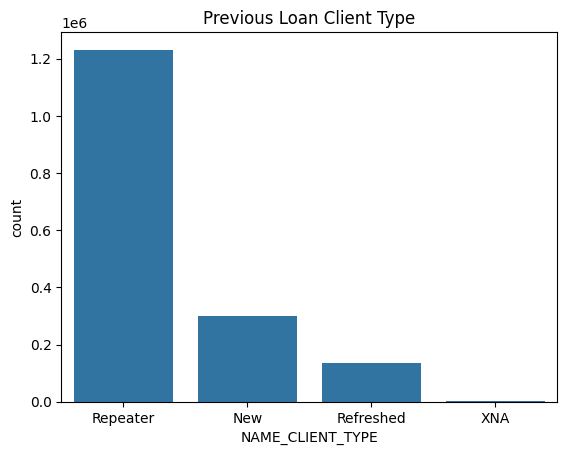

In [744]:
# visualize the value proportions

sns.barplot(df['NAME_CLIENT_TYPE'].value_counts())
plt.title('Previous Loan Client Type');

In [745]:
# create a new df for this feature

prev_client_type = df[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CLIENT_TYPE']].copy()

# create binary column for each type
prev_client_type['prev_client_type_repeater'] = (prev_client_type['NAME_CLIENT_TYPE'] == 'Repeater').astype(int)
prev_client_type['prev_client_type_new'] = (prev_client_type['NAME_CLIENT_TYPE'] == 'New').astype(int)
prev_client_type['prev_client_type_refreshed'] = (prev_client_type['NAME_CLIENT_TYPE'] == 'Refreshed').astype(int)
prev_client_type['prev_client_type_XNA'] = (prev_client_type['NAME_CLIENT_TYPE'] == 'XNA').astype(int)

# drop unnecessary columns
prev_client_type.drop(columns=['SK_ID_PREV','NAME_CLIENT_TYPE'], inplace=True)

prev_client_type

,SK_ID_CURR,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA
0,271877,1,0,0,0
1,108129,1,0,0,0
2,122040,1,0,0,0
3,176158,1,0,0,0
4,202054,1,0,0,0
...,...,...,...,...,...
1670209,352015,0,0,1,0
1670210,334635,0,1,0,0
1670211,249544,1,0,0,0
1670212,400317,1,0,0,0


In [746]:
# groupby SK_ID_CURR and sum the values

prev_client_type = prev_client_type.groupby('SK_ID_CURR').sum()

#reset index
prev_client_type = prev_client_type.reset_index()
prev_client_type

,SK_ID_CURR,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA
0,100001,0,0,1,0
1,100002,0,1,0,0
2,100003,1,0,2,0
3,100004,0,1,0,0
4,100005,1,1,0,0
...,...,...,...,...,...
338852,456251,0,1,0,0
338853,456252,0,1,0,0
338854,456253,1,0,1,0
338855,456254,1,1,0,0


In [747]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, prev_client_type, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle,prev_insured,prev_contract_type_cash,prev_contract_type_consumer,prev_contract_type_revolving,prev_contract_type_XNA,prev_purpose_building,prev_purpose_business,prev_purpose_garage,prev_purpose_holiday_home,prev_purpose_buy_home,prev_purpose_new_car,prev_purpose_used_car,prev_purpose_car_repair,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0,1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,0,2,0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0
338854,456253,0.831397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,2.0,0.0,0.0,0.0,1.0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,0,1,0
338855,456254,1.122050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,2,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,1,0,0


### PRODUCT_COMBINATION

In [748]:
# check values

df['PRODUCT_COMBINATION'].value_counts()

PRODUCT_COMBINATION
Cash                              285990
POS household with interest       263622
POS mobile with interest          220670
Cash X-Sell: middle               143883
Cash X-Sell: low                  130248
Card Street                       112582
POS industry with interest         98833
POS household without interest     82908
Card X-Sell                        80582
Cash Street: high                  59639
Cash X-Sell: high                  59301
Cash Street: middle                34658
Cash Street: low                   33834
POS mobile without interest        24082
POS other with interest            23879
POS industry without interest      12602
POS others without interest         2555
Name: count, dtype: int64

In [749]:
# separate into a new df

product_combos_df = df[['SK_ID_CURR','SK_ID_PREV','PRODUCT_COMBINATION']].copy()
product_combos_df

,SK_ID_CURR,SK_ID_PREV,PRODUCT_COMBINATION
0,271877,2030495,POS mobile with interest
1,108129,2802425,Cash X-Sell: low
2,122040,2523466,Cash X-Sell: high
3,176158,2819243,Cash X-Sell: middle
4,202054,1784265,Cash Street: high
...,...,...,...
1670209,352015,2300464,POS industry with interest
1670210,334635,2357031,POS industry with interest
1670211,249544,2659632,POS household with interest
1670212,400317,2785582,Cash X-Sell: low


In [750]:
# create a column transformer for one hot encoding

product_combos_preprocessor = ColumnTransformer([
  ('ohe', ohe, ['PRODUCT_COMBINATION'])
], remainder='passthrough', verbose_feature_names_out=False)

ohe_product_combos = product_combos_preprocessor.fit_transform(product_combos_df)

ohe_product_combos

,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,SK_ID_CURR,SK_ID_PREV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,271877,2030495
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108129,2802425
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122040,2523466
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176158,2819243
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202054,1784265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,352015,2300464
1670210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,334635,2357031
1670211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249544,2659632
1670212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400317,2785582


In [751]:
# groupby SK_ID_CURR and sum values

ohe_product_combos = pd.DataFrame(ohe_product_combos.groupby('SK_ID_CURR').sum()).reset_index()
ohe_product_combos.drop(columns='SK_ID_PREV', inplace=True)
ohe_product_combos

,SK_ID_CURR,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,100005,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
338853,456252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338854,456253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
338855,456254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [752]:
# merge into the engineered dataframe

engineered_prev = pd.merge(engineered_prev, ohe_product_combos, on='SK_ID_CURR', how='outer')

engineered_prev

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle,prev_insured,prev_contract_type_cash,prev_contract_type_consumer,prev_contract_type_revolving,prev_contract_type_XNA,prev_purpose_building,prev_purpose_business,prev_purpose_garage,prev_purpose_holiday_home,prev_purpose_buy_home,prev_purpose_new_car,prev_purpose_used_car,prev_purpose_car_repair,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0,1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
338853,456252,0.986561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### DAYS_TERMINATION

In [753]:
# check values

df['DAYS_TERMINATION'].describe()

count    997149.000000
mean      81992.343838
std      153303.516729
min       -2874.000000
25%       -1270.000000
50%        -499.000000
75%         -44.000000
max      365243.000000
Name: DAYS_TERMINATION, dtype: float64

<Axes: >

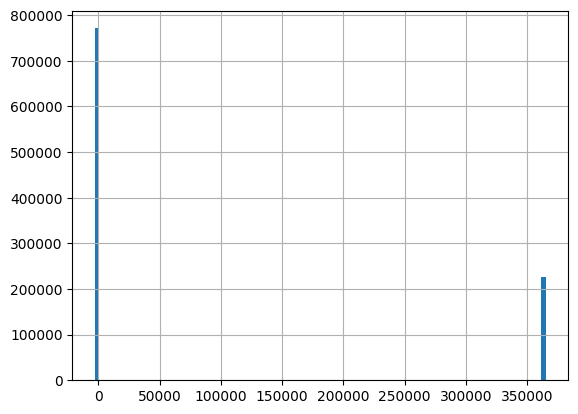

In [754]:
# check the distribution

df['DAYS_TERMINATION'].hist(bins=100)

In [755]:
# check the max

pd.set_option('display.max_columns', None)

df[df['DAYS_TERMINATION']== 365243]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,prev_ratio_credit_approved
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,1.11880
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,1.21284
17,1285768,142748,Revolving loans,9000.000,180000.0,180000.0,NaN,180000.0,FRIDAY,13,Y,1,NaN,NaN,NaN,XAP,Approved,-336,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,x-sell,AP+ (Cash loan),6,XNA,0.0,XNA,Card X-Sell,-277.0,-257.0,365243.0,365243.0,365243.0,0.0,1.00000
21,1182516,267782,Cash loans,20361.600,405000.0,451777.5,NaN,405000.0,SATURDAY,4,Y,1,NaN,NaN,NaN,XNA,Approved,-686,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,30.0,low_normal,Cash X-Sell: low,365243.0,-656.0,214.0,365243.0,365243.0,1.0,1.11550
34,1629736,255331,Revolving loans,10125.000,202500.0,202500.0,NaN,202500.0,SATURDAY,14,Y,1,NaN,NaN,NaN,XAP,Approved,-284,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,-265.0,-234.0,365243.0,365243.0,365243.0,0.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669925,2126826,366227,Cash loans,30205.350,450000.0,491580.0,NaN,450000.0,WEDNESDAY,10,Y,1,NaN,NaN,NaN,Furniture,Approved,-358,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,middle,Cash Street: middle,365243.0,-327.0,363.0,365243.0,365243.0,0.0,1.09240
1669945,1669699,158720,Consumer loans,11204.865,113940.0,113940.0,0.0,113940.0,MONDAY,13,Y,1,0.0,NaN,NaN,XAP,Approved,-203,XNA,XAP,NaN,Repeater,Tourism,POS,XNA,Stone,20,Tourism,12.0,middle,POS other with interest,365243.0,-170.0,160.0,365243.0,365243.0,0.0,1.00000
1669960,1731392,180860,Revolving loans,11250.000,0.0,225000.0,NaN,NaN,TUESDAY,17,Y,1,NaN,NaN,NaN,XAP,Approved,-1155,XNA,XAP,NaN,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,-1083.0,-1055.0,365243.0,-354.0,365243.0,0.0,1.00000
1670192,2101747,339383,Revolving loans,3375.000,0.0,67500.0,NaN,NaN,FRIDAY,18,Y,1,NaN,NaN,NaN,XAP,Approved,-540,XNA,XAP,NaN,Refreshed,XNA,Cards,x-sell,AP+ (Cash loan),10,XNA,0.0,XNA,Card X-Sell,-474.0,-438.0,365243.0,365243.0,365243.0,0.0,1.00000


- 365243 seems like a placeholder value for loans that have been Approved, but not active

# Check correlations between the engineered features

In [756]:
# check the final engineered features for NaN's before export

engineered_prev.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338857 entries, 0 to 338856
Data columns (total 73 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   SK_ID_CURR                                          338857 non-null  int64  
 1   prev_avg_ratio_credit_approved                      338605 non-null  float64
 2   prev_reject_CLIENT                                  338857 non-null  float64
 3   prev_reject_HC                                      338857 non-null  float64
 4   prev_reject_LIMIT                                   338857 non-null  float64
 5   prev_reject_SCO                                     338857 non-null  float64
 6   prev_reject_SCOFR                                   338857 non-null  float64
 7   prev_reject_SYSTEM                                  338857 non-null  float64
 8   prev_reject_VERIF                                   338857 non-n

In [757]:
# check the dython correlations for the engineered features

dython_engineered_prev = associations(engineered_prev, compute_only=True)['corr']


In [758]:
# sort by the features with the highest correlations to prev_status_refused

dython_engineered_prev['prev_status_refused'].sort_values(ascending=False)

prev_status_refused                                1.000000
prev_binary_rejected                               0.984741
prev_reject_HC                                     0.847225
prev_client_type_repeater                          0.698468
prev_contract_type_cash                            0.642032
                                                     ...   
pre_purpose_hobby                                  0.016974
prev_purpose_borrow                                0.015495
PRODUCT_COMBINATION_POS others without interest    0.010322
prev_purpose_refuse                                0.007349
SK_ID_CURR                                         0.002534
Name: prev_status_refused, Length: 73, dtype: float64

In [759]:
# sort by the features with the highest correlations to prev_status_refused

dython_engineered_prev['prev_binary_rejected'].sort_values(ascending=False)

prev_binary_rejected                               1.000000
prev_status_refused                                0.984741
prev_reject_HC                                     0.832068
prev_client_type_repeater                          0.704450
prev_contract_type_cash                            0.628021
                                                     ...   
pre_purpose_hobby                                  0.016261
prev_purpose_borrow                                0.014907
PRODUCT_COMBINATION_POS others without interest    0.010332
prev_purpose_refuse                                0.007326
SK_ID_CURR                                         0.002512
Name: prev_binary_rejected, Length: 73, dtype: float64

# Export engineered features dataframe to CSV

In [760]:
# check the dataframe before export

engineered_prev.head()

,SK_ID_CURR,prev_avg_ratio_credit_approved,prev_reject_CLIENT,prev_reject_HC,prev_reject_LIMIT,prev_reject_SCO,prev_reject_SCOFR,prev_reject_SYSTEM,prev_reject_VERIF,prev_reject_XAP,prev_reject_XNA,prev_binary_rejected,prev_status_approved,prev_status_canceled,prev_status_refused,prev_status_unused,prev_yield_XNA,prev_yield_high,prev_yield_low_action,prev_yield_low_normal,prev_yield_middle,prev_insured,prev_contract_type_cash,prev_contract_type_consumer,prev_contract_type_revolving,prev_contract_type_XNA,prev_purpose_building,prev_purpose_business,prev_purpose_garage,prev_purpose_holiday_home,prev_purpose_buy_home,prev_purpose_new_car,prev_purpose_used_car,prev_purpose_car_repair,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100001,0.957782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100002,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,100003,1.057664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,3,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0,1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,100005,0.899950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,1,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [761]:
# export to csv

# engineered_prev.to_csv('../data/engineered_previous_application.csv', index=False)